In [1]:
%load_ext autoreload
%autoreload 2

# data processing
import torch.nn.functional as F
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Statistics (correlation)
from scipy.stats import pearsonr, spearmanr

# libraries for the model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score


In [2]:
# Custom functions
from pt_helpers import *

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Load the training data
This is the clean data that we processed in the notebook `Training_data_preparation`

In [5]:
data_path = "DATA/training_data/"
df = pd.read_csv(data_path + "VEX_edac_mag_labeled_15min_nan.csv", index_col=0)
df.index = pd.to_datetime(df.index)

We separate the feature matrix `X` and the labels `y`.
- `X` will contain X Y and Z coordinates of the magnetic field

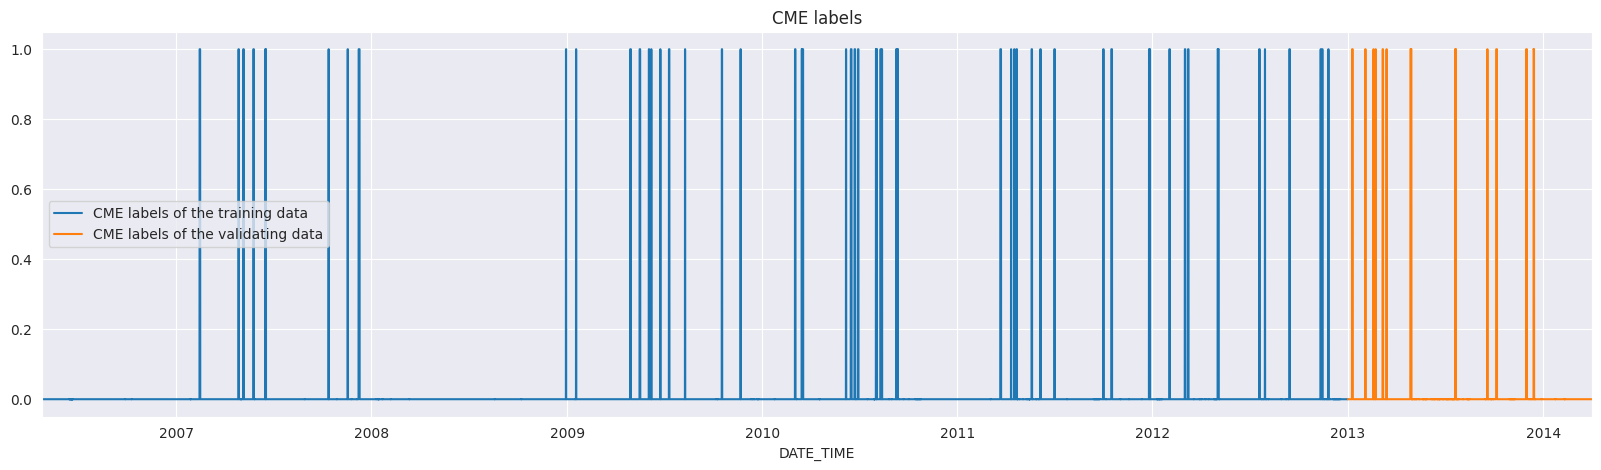

In [6]:
df_train = df.loc[:'2012-12-31'].copy()
df_test = df.loc['2013-01-01':'2014-04-01'].copy()

features = ['BX', 'BY', 'BZ', 'RSC']
label_feature = 'cme'

_, ax = plt.subplots(figsize=(20, 5))
df_train[label_feature].plot(ax=ax, label="CME labels of the training data")
df_test[label_feature].plot(ax=ax, label="CME labels of the validating data")
plt.title("CME labels")
plt.legend()
plt.show()

In [8]:
# Create the feature matrix and the labels
y_tr = df_train[label_feature].values
X_tr = df_train[features].values
y_te = df_test[label_feature].values
X_te = df_test[features].values

# Standardize the data
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_te = scaler.transform(X_te)

print("Shape of y:", y_tr.shape)
print("Shape of X:", X_tr.shape)
print("Shape of y_test:", y_te.shape)
print("Shape of X_test:", X_te.shape)

Shape of y: (234624,)
Shape of X: (234624, 4)
Shape of y_test: (43776,)
Shape of X_test: (43776, 4)


## LSTM

In [9]:
time_steps = 36 // 2   # 6 hours of data
n_features = len(features) # Number of features

X_train, y_train = create_sequences_without_nan(X_tr, y_tr, time_steps)
X_val, y_val = create_sequences_without_nan(X_te, y_te, time_steps)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

y_train = (y_train > 0.5).astype(int)
y_val = (y_val > 0.5).astype(int)

print("Check for NaNs:")
print(np.isnan(X_train).sum())
print(np.isnan(X_val).sum())

(232610, 18, 4) (232610,)
(43258, 18, 4) (43258,)
Check for NaNs:
0
0


In [11]:
# Augment the data
X_train_aug, y_train_aug = augment_data(X_train, y_train, label_to_augment=1, factor=10, std=0.1)
print(X_train_aug.shape, y_train_aug.shape, X_val.shape, y_val.shape)

(274680, 18, 4) (274680,) (54318, 18, 4) (54318,)


In [9]:
def create_data_loader(X, y, batch_size, shuffle=False):
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32).to(device), torch.tensor(y, dtype=torch.float32).to(device))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Create DataLoaders
batch_size = 128  
train_loader = create_data_loader(X_train_aug, y_train_aug, batch_size, shuffle=True)
val_loader = create_data_loader(X_val, y_val, batch_size)

In [10]:
class CMEPredictor(nn.Module):
    def __init__(self, n_features, n_hidden=50, n_layers=1, dropout=0.0):
        super(CMEPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=n_hidden, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(n_hidden, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return torch.sigmoid(x)

In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch)
            predicted = (outputs > 0.5).float()  # Using 0.5 as the threshold for binary classification
            predictions.extend(predicted.view(-1).tolist())
            true_labels.extend(y_batch.tolist())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)

    print(f'Accuracy: {accuracy}')
    print(f'F1 Score: {f1}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

In [ ]:
def train_model(model, train_loader, eval_loader, criterion, optimizer, n_epochs):
    loss = -1
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch.view(-1, 1))
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for X_batch, y_batch in eval_loader:
                val_output = model(X_batch)
                val_loss += criterion(val_output, y_batch.view(-1, 1)).item()
        val_loss /= len(eval_loader)
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Val Loss: {val_loss}')

# Training parameters

In [11]:
n_hidden = 5
n_layers = 2
dropout = 0.2

model = CMEPredictor(n_features, n_hidden, n_layers, dropout=dropout).to(device)
w_model = CMEPredictor(n_features, n_hidden, n_layers, dropout=dropout).to(device)

lr = 0.001
n_epochs = 10
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

### Training and evaluation

In [14]:
# train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs)

In [15]:
# print("Train")
# evaluate_model(model, train_loader)
# print()
# print("Eval")
# evaluate_model(model, val_loader)

Train

Eval


## LSTM with class weights

In [16]:
optimizer = optim.Adam(w_model.parameters(), lr=lr)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_aug), y=y_train_aug)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.BCELoss(weight=class_weights[1])  # Use the class weights in your loss function
print(class_weights)

tensor([ 0.5092, 27.6456], device='cuda:0')


# Train the model

In [17]:
train_model(w_model, train_loader, val_loader, criterion, optimizer, n_epochs)

Epoch 1, Loss: 0.3222329914569855, Val Loss: 2.4725187190714673
Epoch 2, Loss: 1.479699969291687, Val Loss: 2.5919731775375867
Epoch 3, Loss: 0.18615412712097168, Val Loss: 2.550418381176933
Epoch 4, Loss: 1.979014277458191, Val Loss: 2.5886698423515586
Epoch 5, Loss: 0.16962885856628418, Val Loss: 2.4995867186198395
Epoch 6, Loss: 0.1328626275062561, Val Loss: 2.494243359931651
Epoch 7, Loss: 0.39092761278152466, Val Loss: 2.540540186126204
Epoch 8, Loss: 1.1048771142959595, Val Loss: 2.5305980269703463
Epoch 9, Loss: 1.2067769765853882, Val Loss: 2.555299377840387
Epoch 10, Loss: 0.9098678231239319, Val Loss: 2.53838477099656


In [18]:
print("Train")
evaluate_model(w_model, train_loader)
print()
print("Eval")
evaluate_model(w_model, val_loader)

Train
Accuracy: 0.9845922359313873
F1 Score: 0.44174454828660437
Precision: 0.6407591504744691
Recall: 0.33705728547658664

Eval
Accuracy: 0.9726062231263581
F1 Score: 0.25142135186355025
Precision: 0.4171907756813417
Recall: 0.17992766726943943


# Plot the predictions and model performance

In [19]:
eval_loader = val_loader
eval_model = w_model

eval_model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    val_loss = 0
    for X_batch, y_batch in eval_loader:
        val_output = eval_model(X_batch)
        predictions.extend(val_output.view(-1).tolist())
        true_labels.extend(y_batch.tolist())

[0.0017176487017422915, 0.0018096690764650702, 0.0019321385771036148, 0.002008462091907859, 0.002216929569840431, 0.0024156933650374413, 0.0025306346360594034, 0.0026356116868555546, 0.002715983660891652, 0.002683014841750264, 0.0026150380726903677, 0.0024715012405067682, 0.0023052359465509653, 0.0021168675739318132, 0.0019089735578745604, 0.0017098896205425262, 0.0015462406445294619, 0.001406895462423563, 0.00129581312648952, 0.0012176984455436468, 0.0011955599766224623, 0.0012076711282134056, 0.0012024306925013661, 0.0012108675437048078, 0.0012274559121578932, 0.0012253806926310062, 0.0012481862213462591, 0.0012296728091314435, 0.0012200670316815376, 0.0012460669968277216, 0.0012668540002778172, 0.0012865038588643074, 0.0012965803034603596, 0.001322613563388586, 0.0013212966732680798, 0.0013313827803358436, 0.0013341036392375827, 0.0013579896185547113, 0.0014006283599883318, 0.001450712326914072, 0.0015512737445533276, 0.001754194381646812, 0.002022359287366271, 0.0020062727853655815

In [20]:
X_after = X_val[:, 0, :]
df_pred = pd.DataFrame({'pred': predictions, 'true': true_labels, 'BX': X_after[:, 0], 'BY': X_after[:, 1], 'BZ': X_after[:, 2]})
df_pred['pred_label'] = (df_pred['pred'] > 0.5).astype(int)

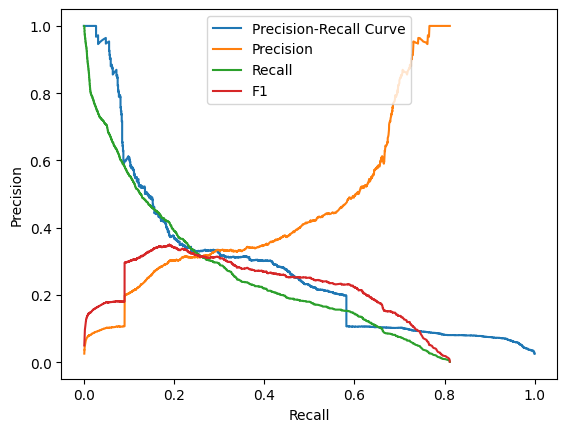

[0. 0. 0. ... 0. 0. 0.]
Accuracy: 0.9726062231263581
F1 Score: 0.25142135186355025
Precision: 0.4171907756813417
Recall: 0.17992766726943943


In [21]:
# Plot recall precision curve
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(df_pred['true'], df_pred['pred'])
f1 = 2 * precision * recall / (precision + recall)
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.plot(thresholds, f1[:-1], label='F1')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

true_labels = df_pred['true'].values
pred = df_pred['pred_label'].values

print(true_labels)
accuracy = accuracy_score(true_labels, pred)
f1 = f1_score(true_labels, pred)
precision = precision_score(true_labels, pred)
recall = recall_score(true_labels, pred)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

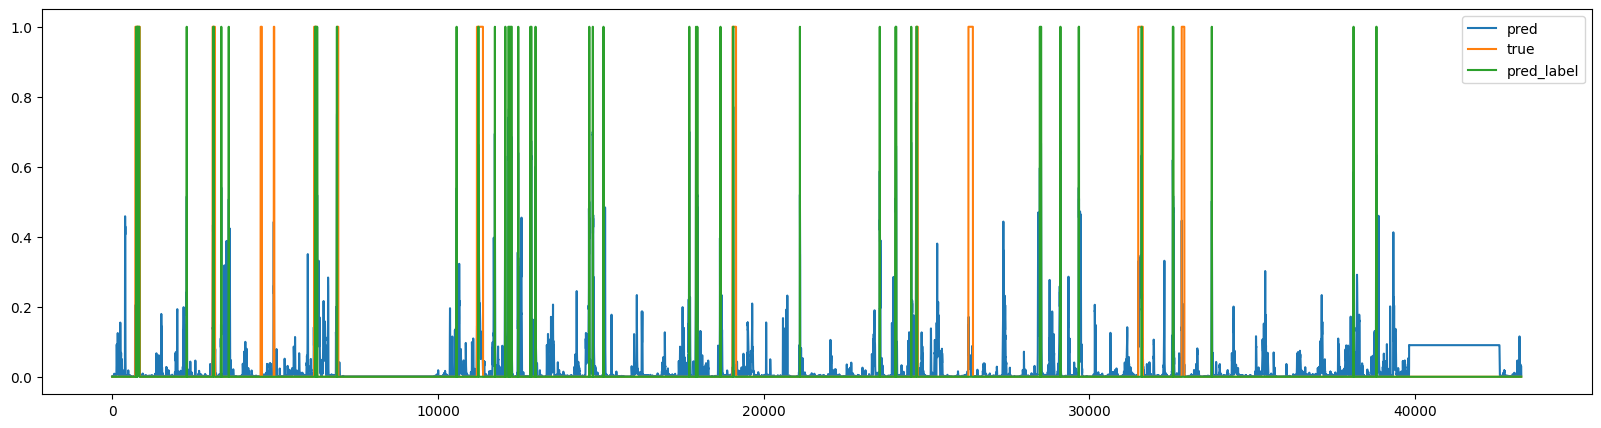

In [22]:
df_pred[['pred', 'true', 'pred_label']].plot(figsize=(20, 5))
plt.show()

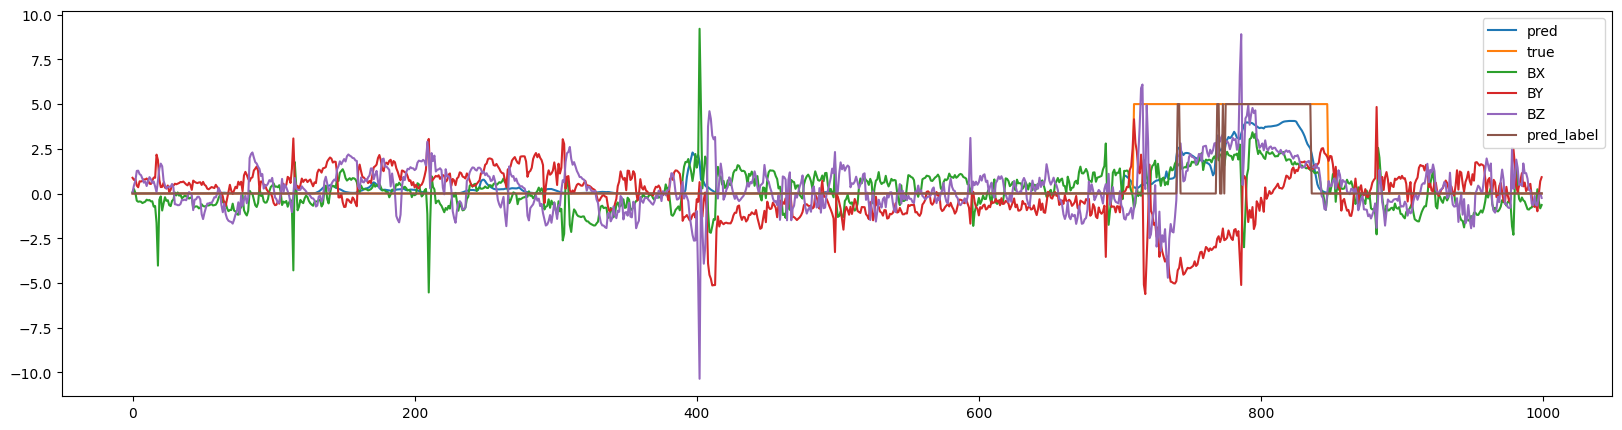

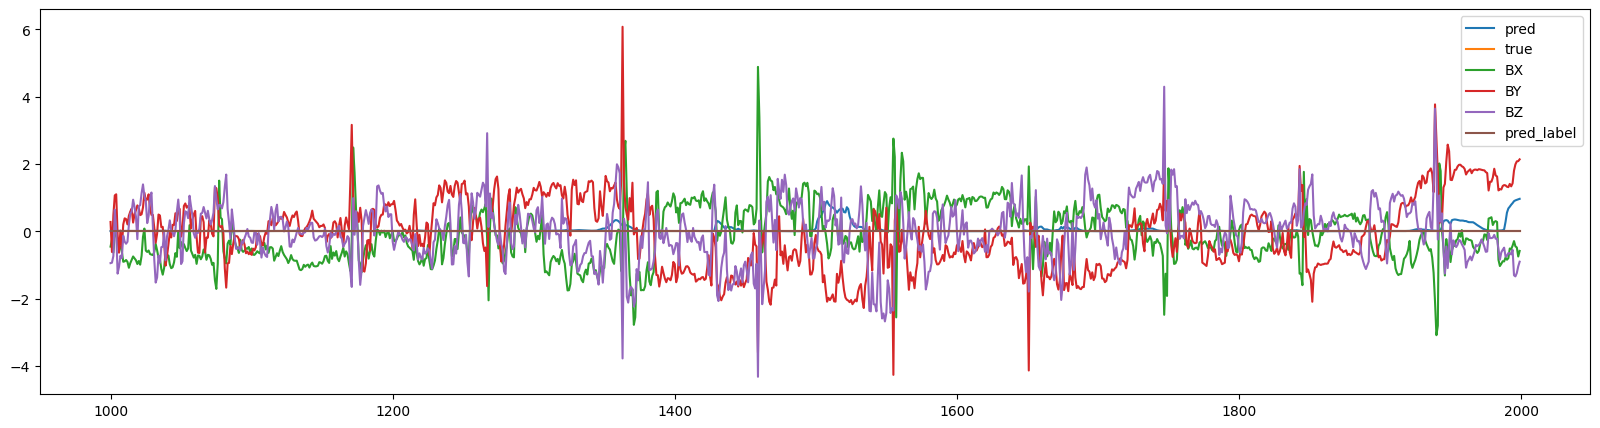

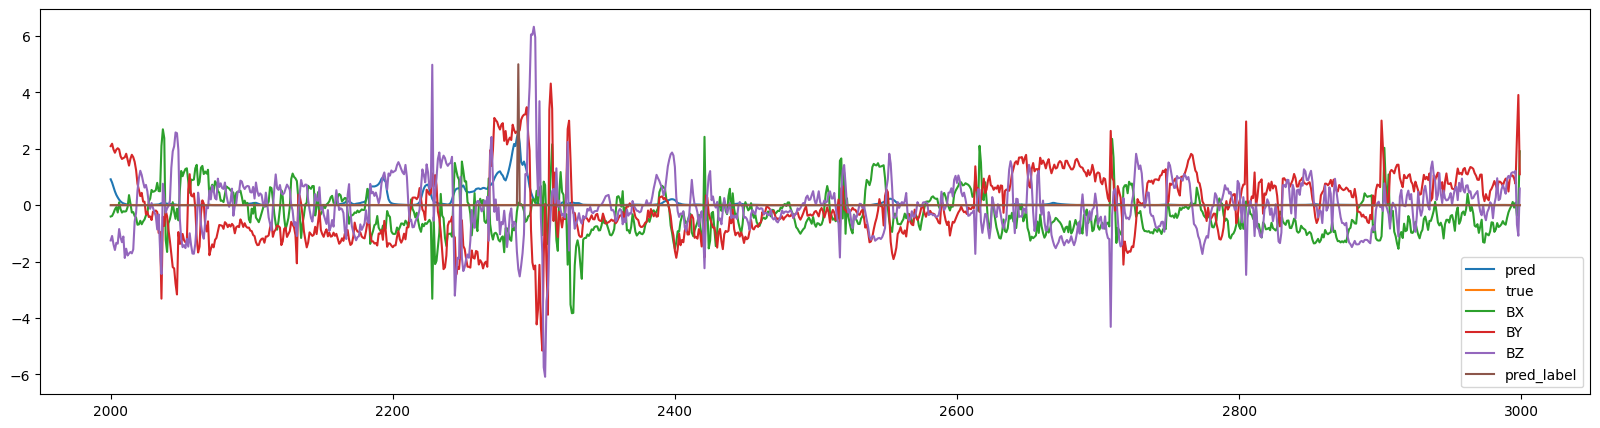

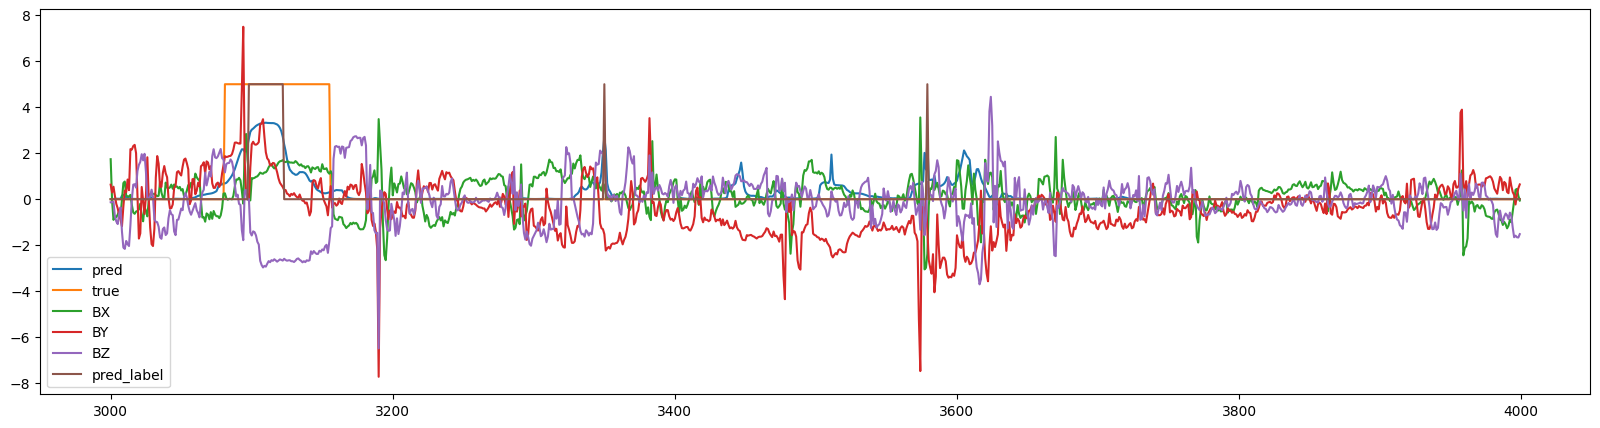

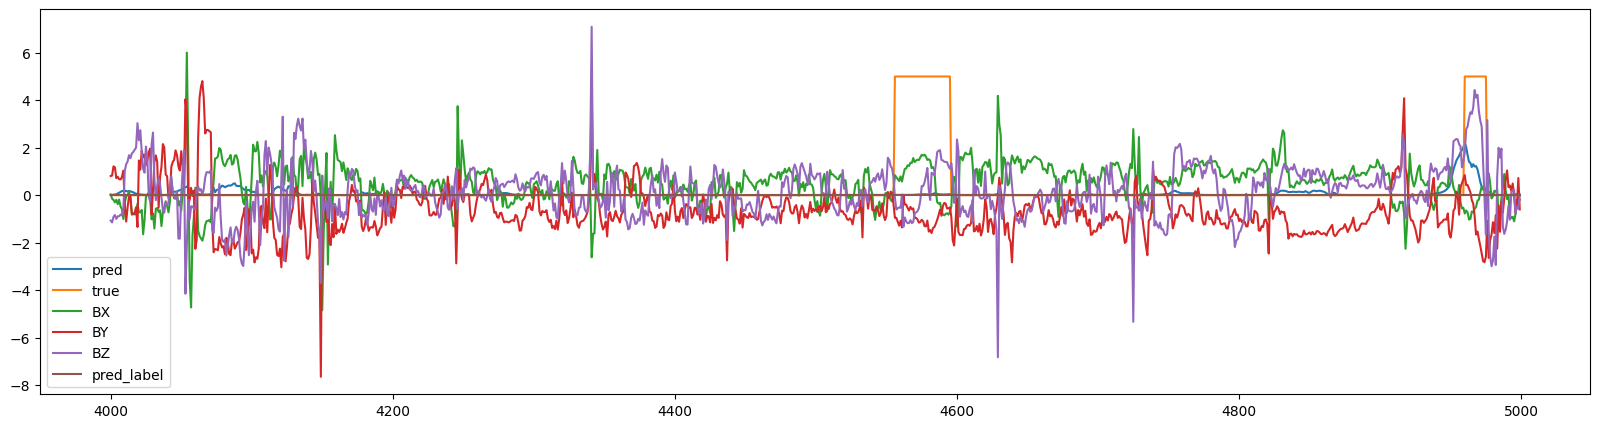

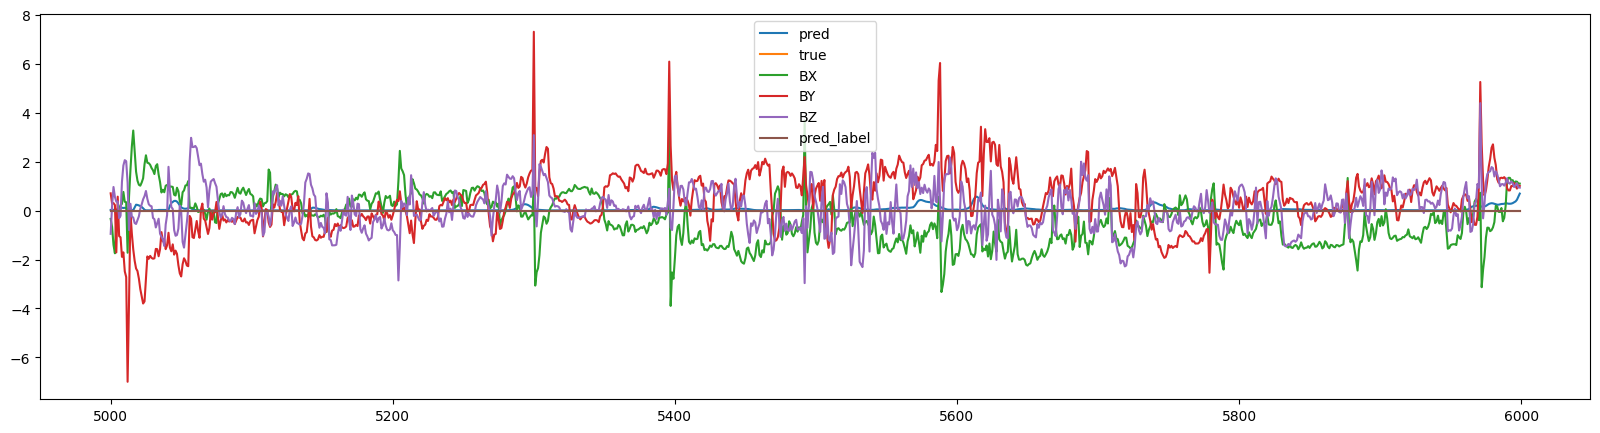

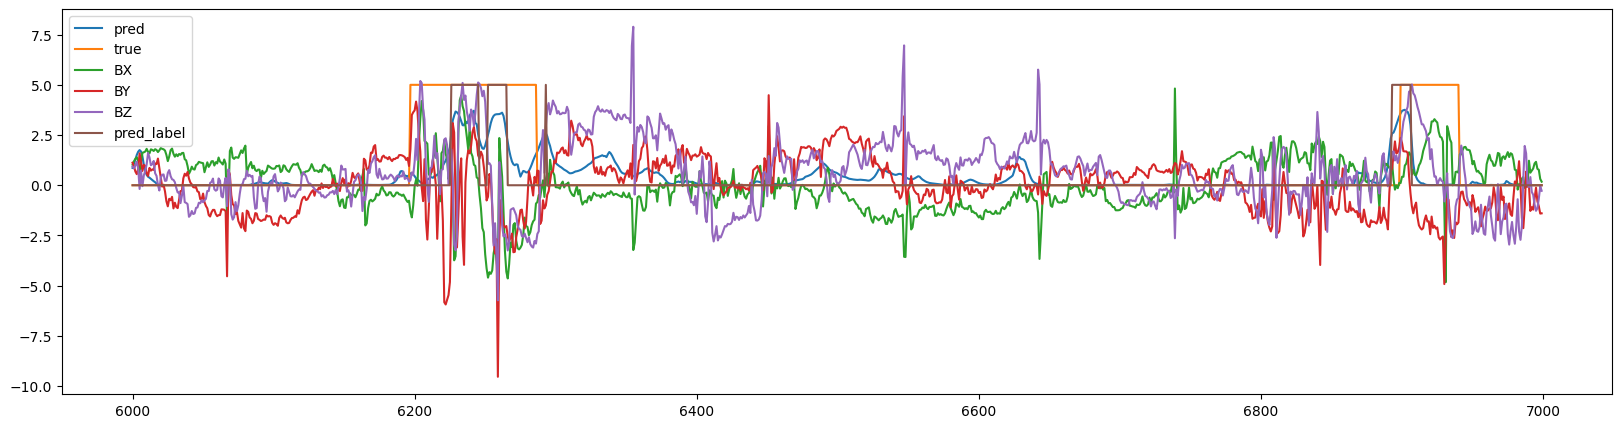

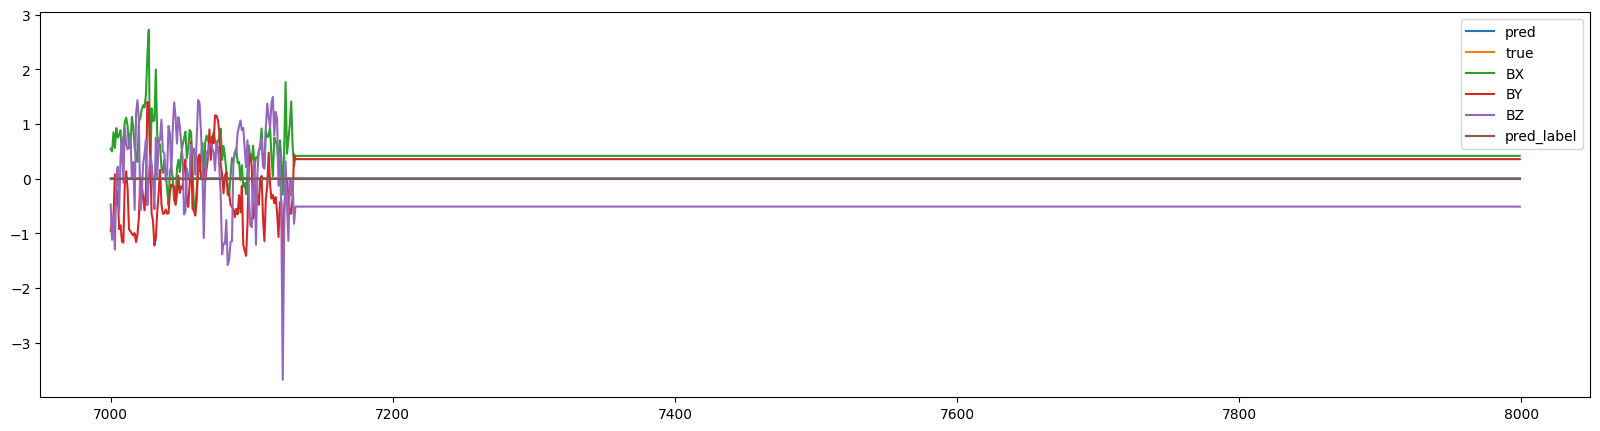

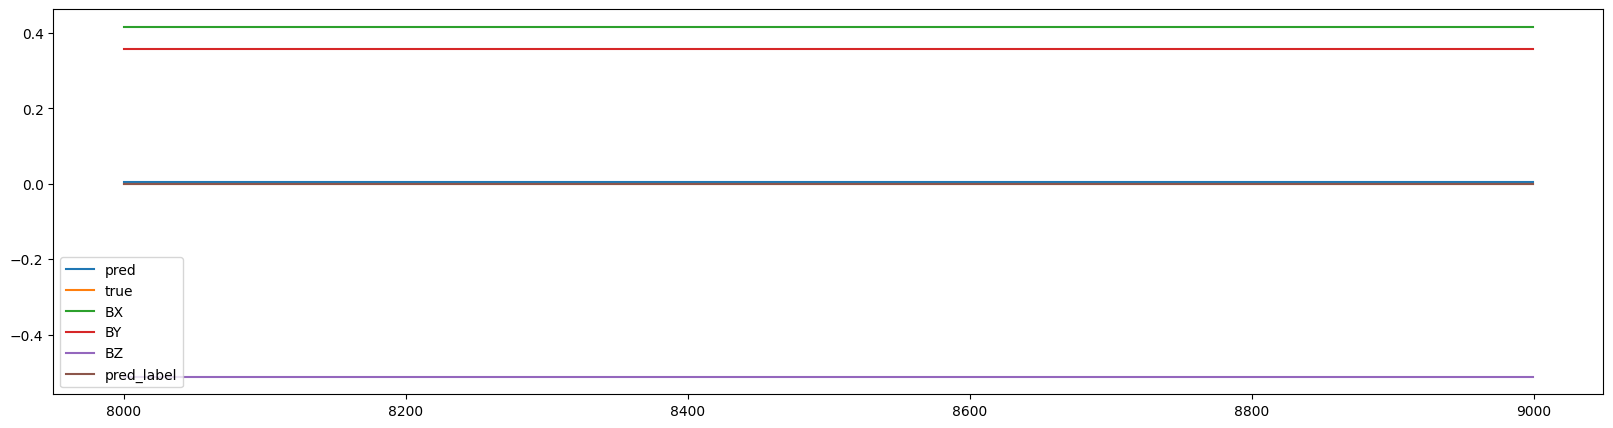

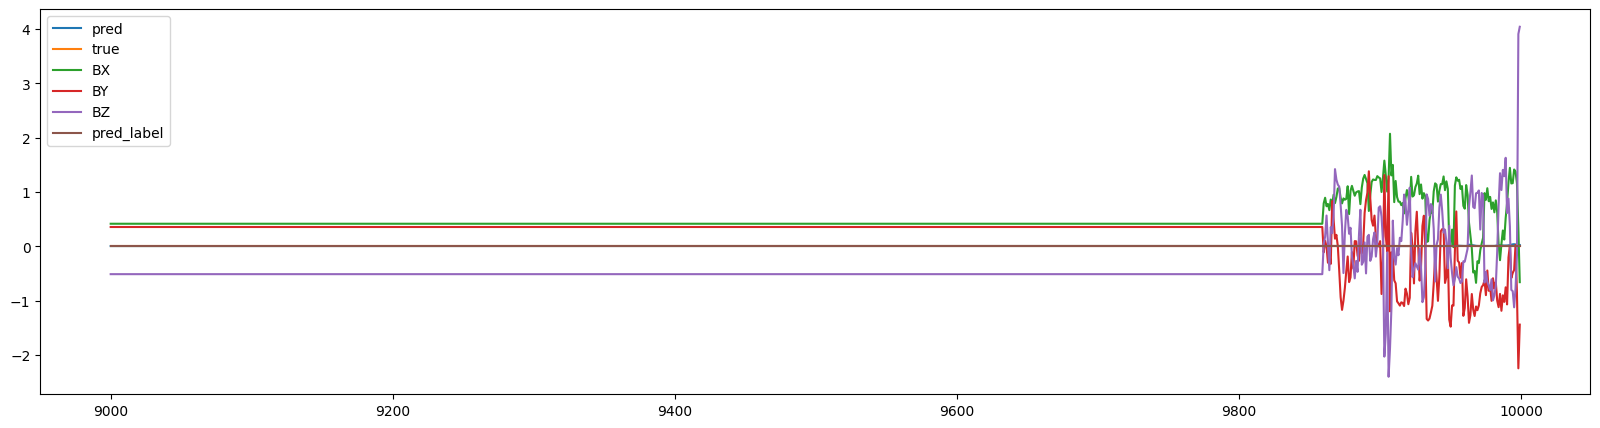

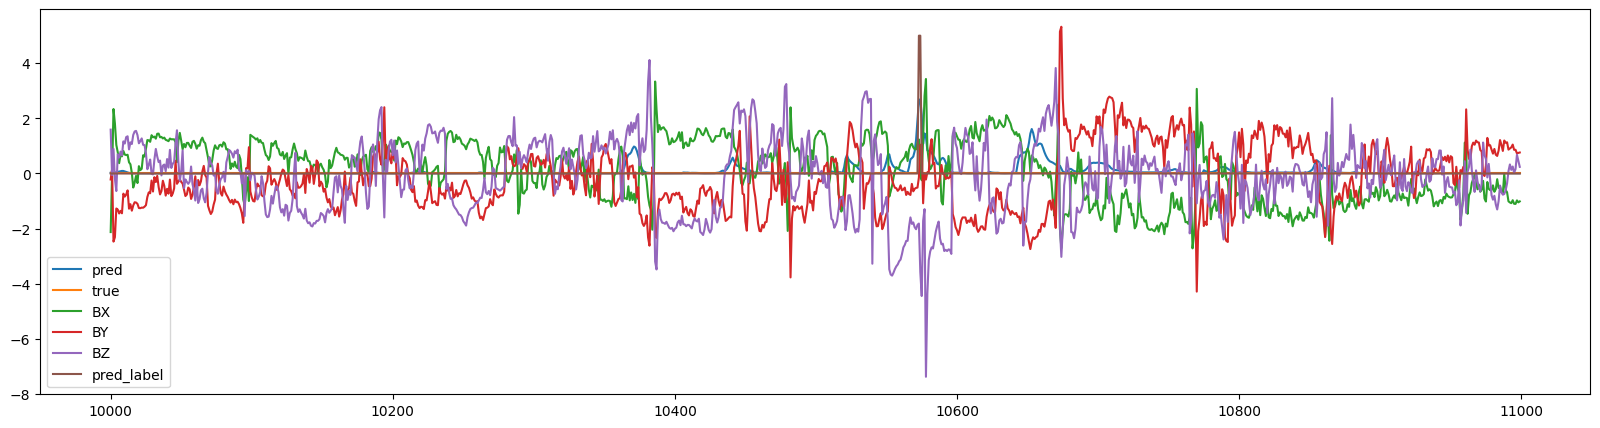

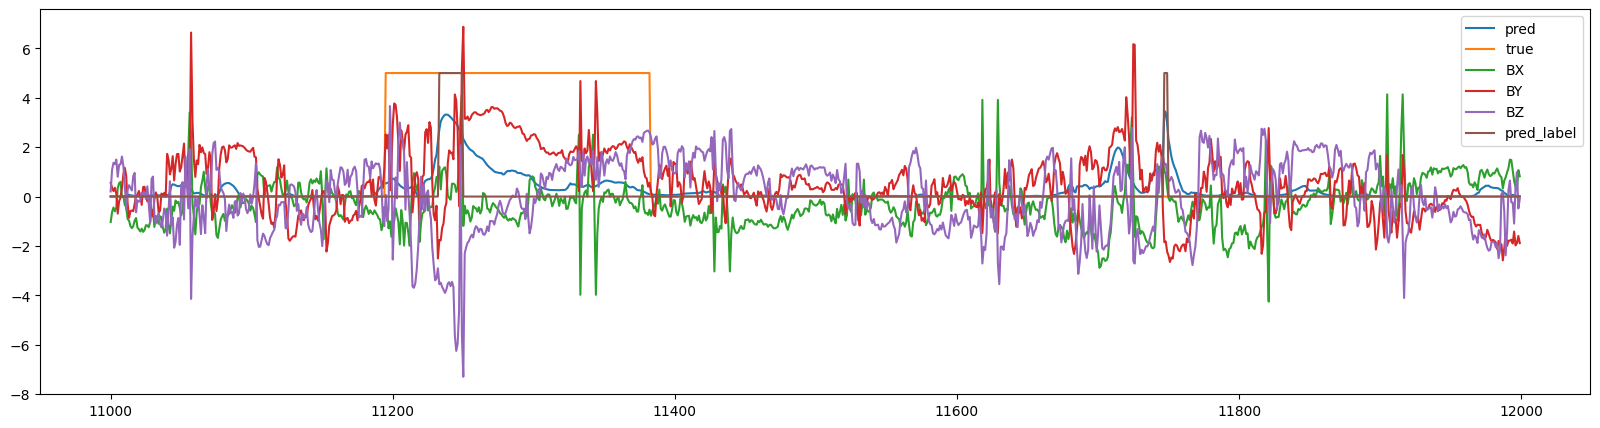

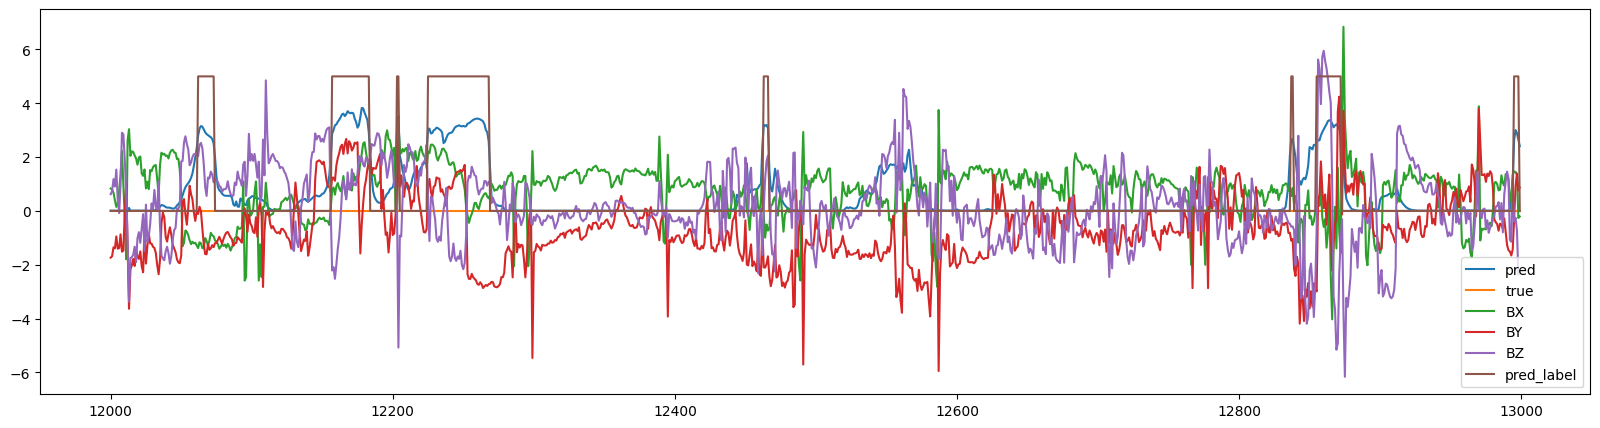

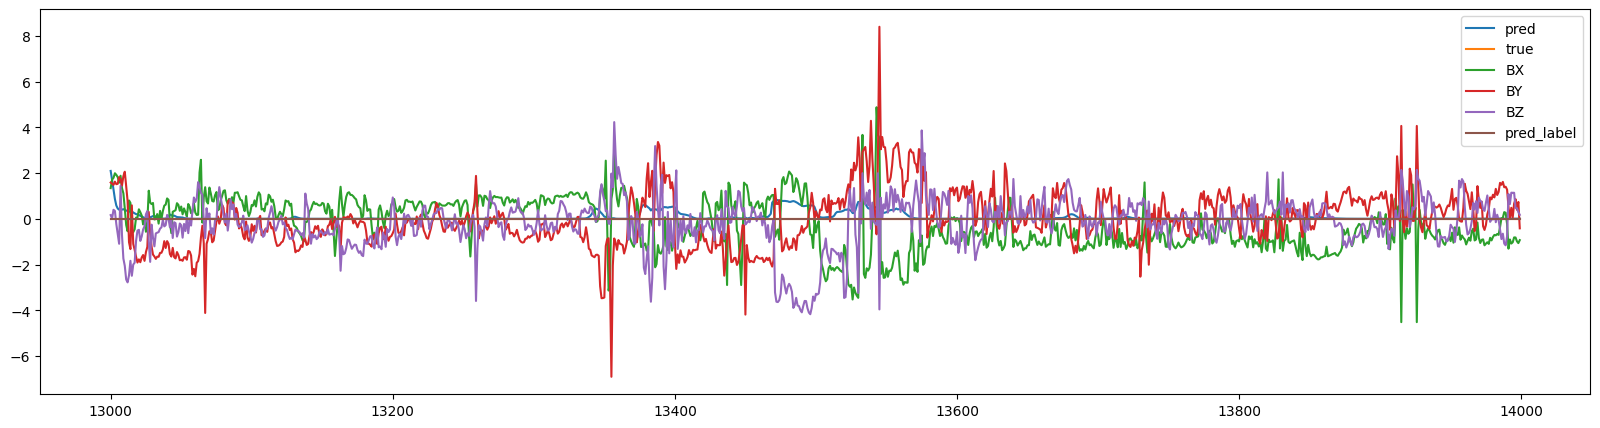

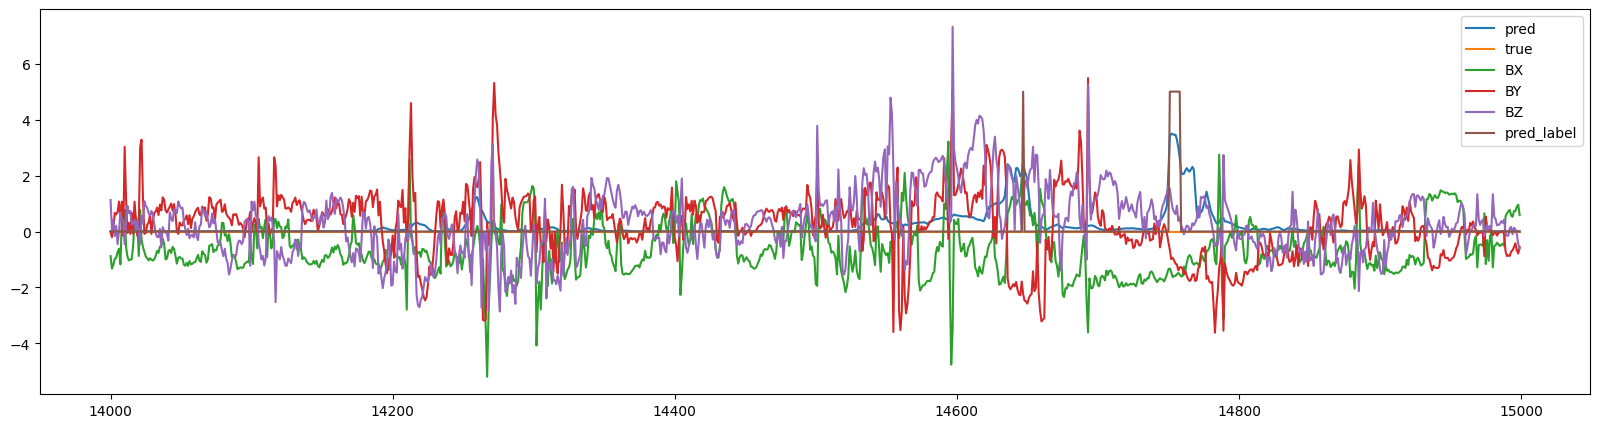

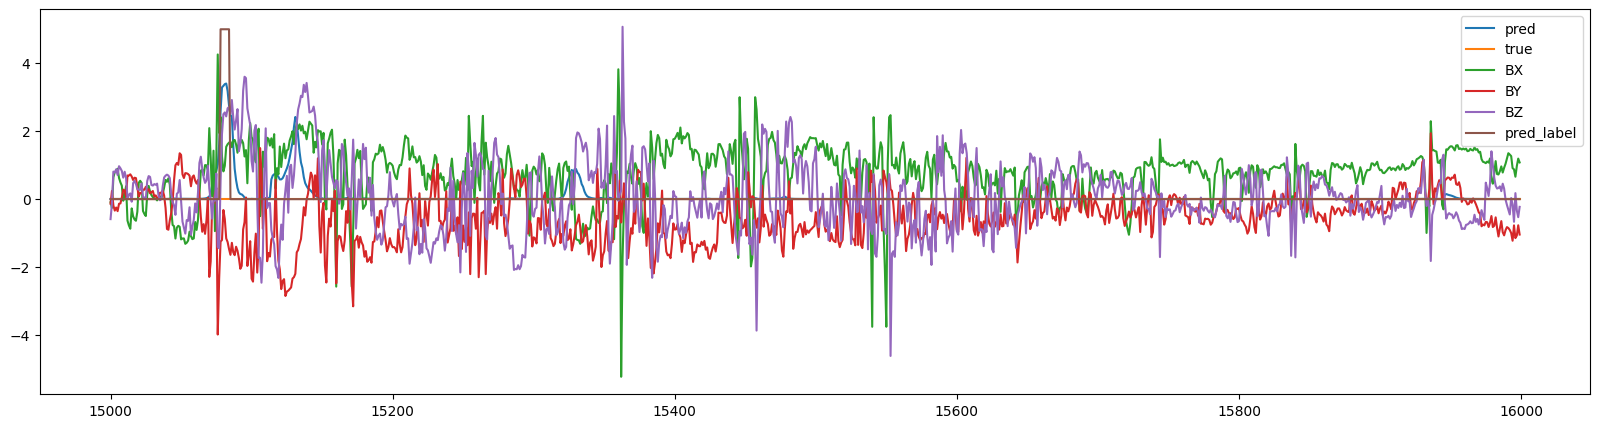

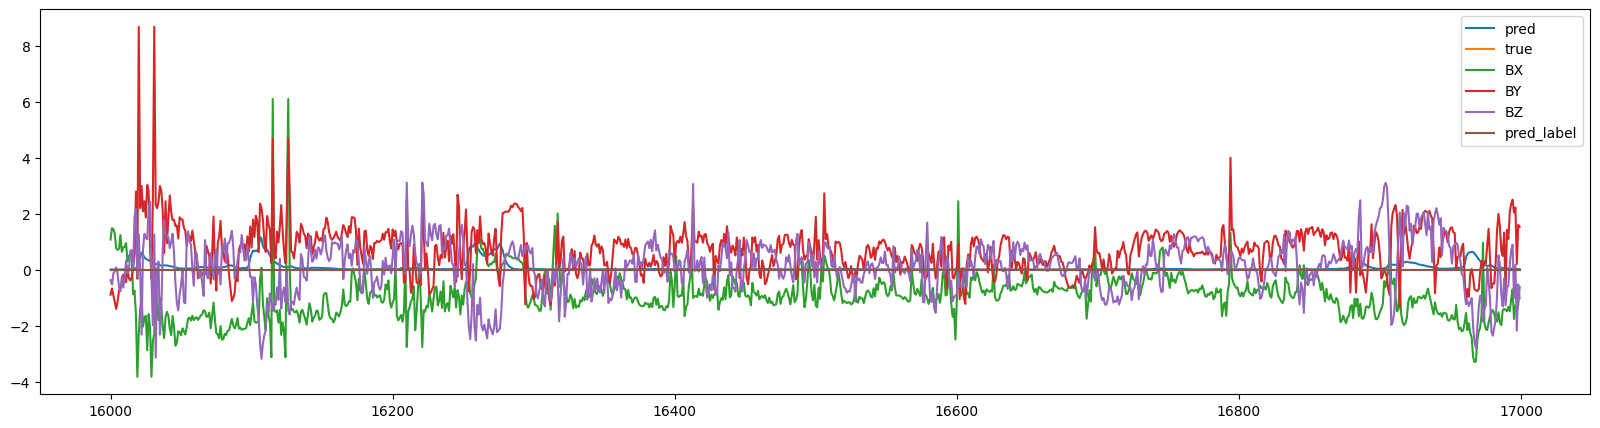

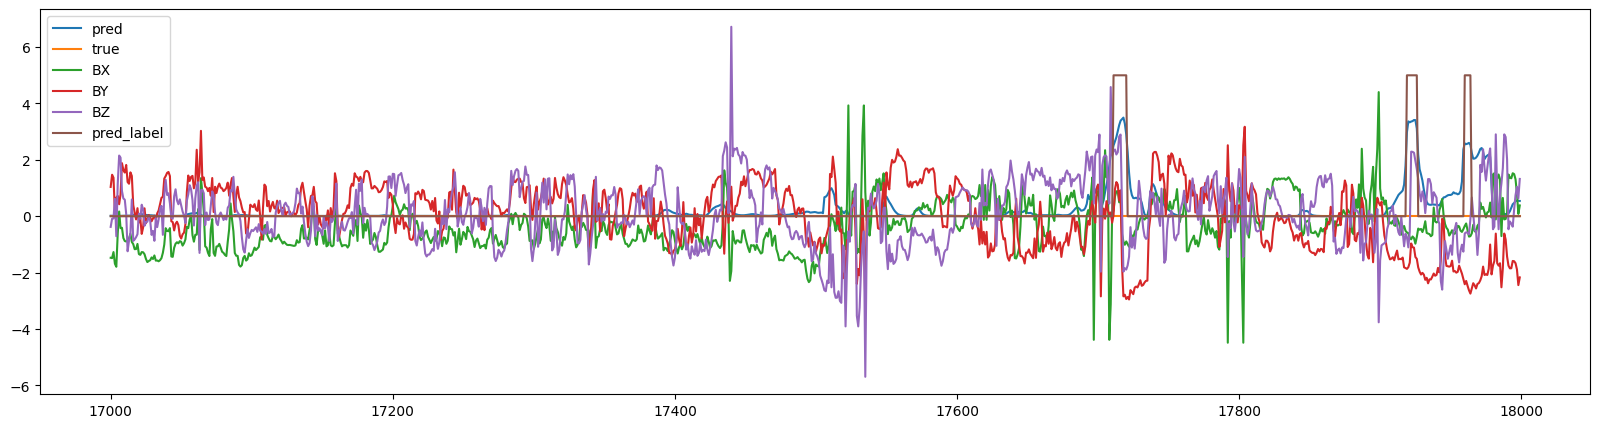

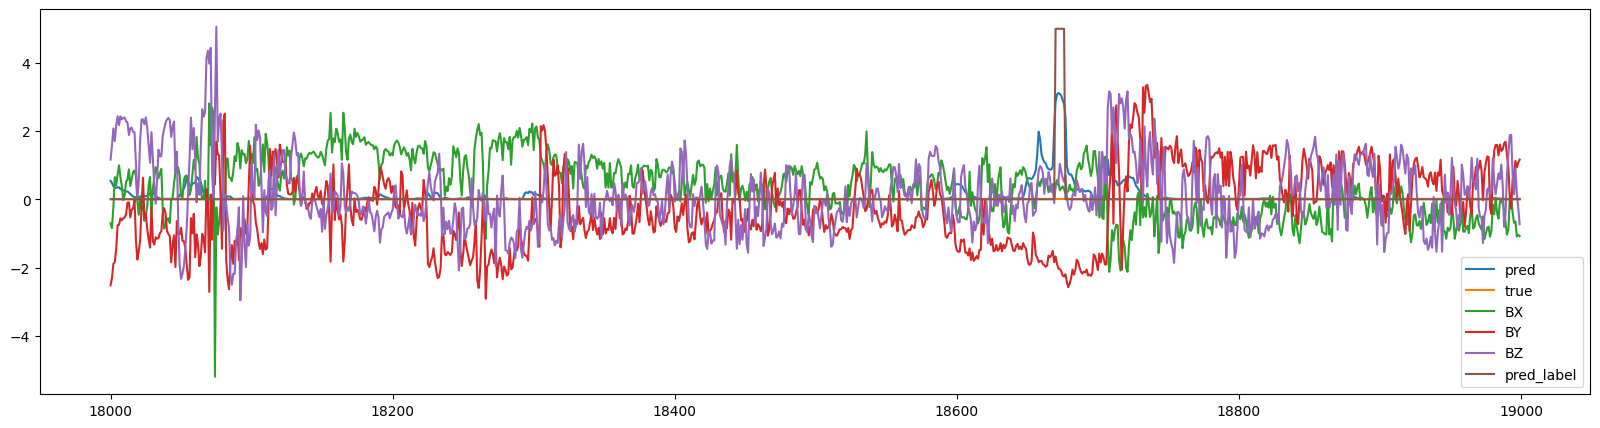

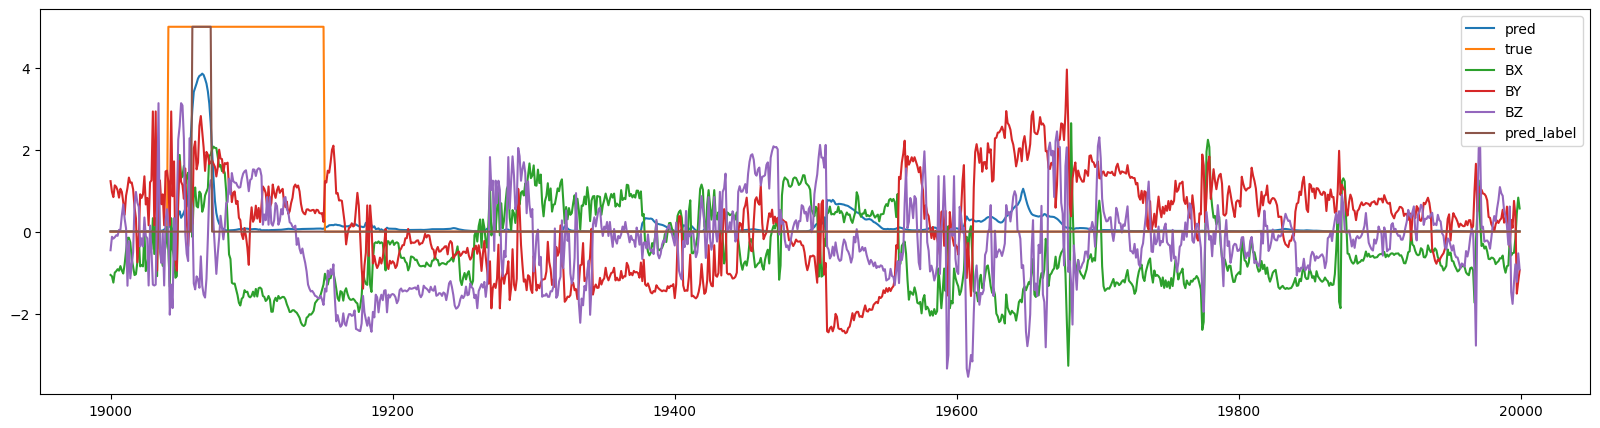

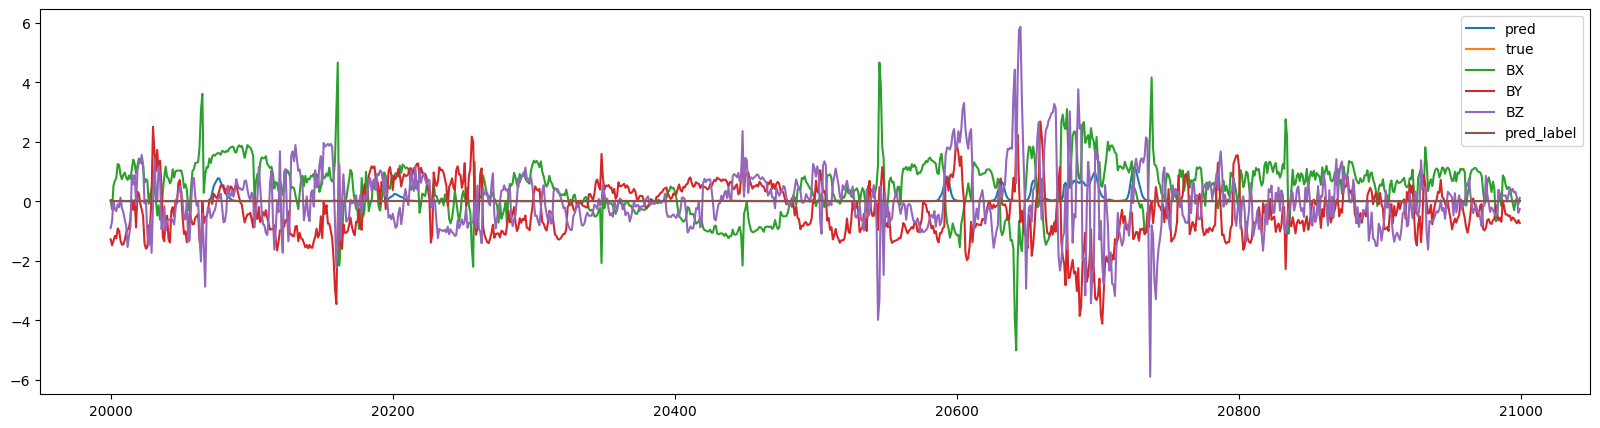

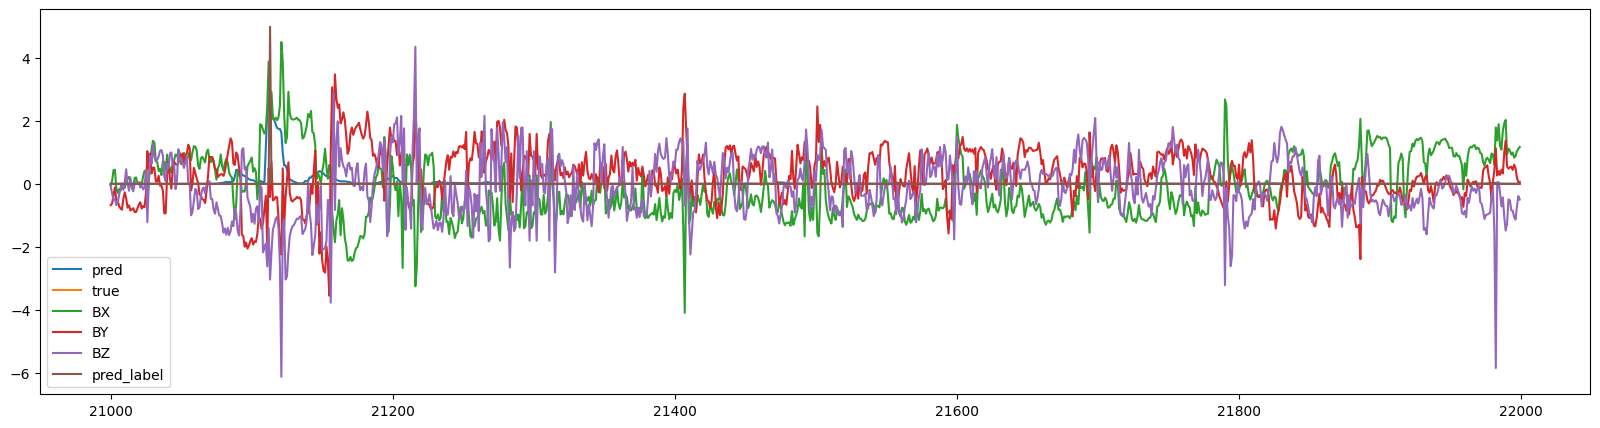

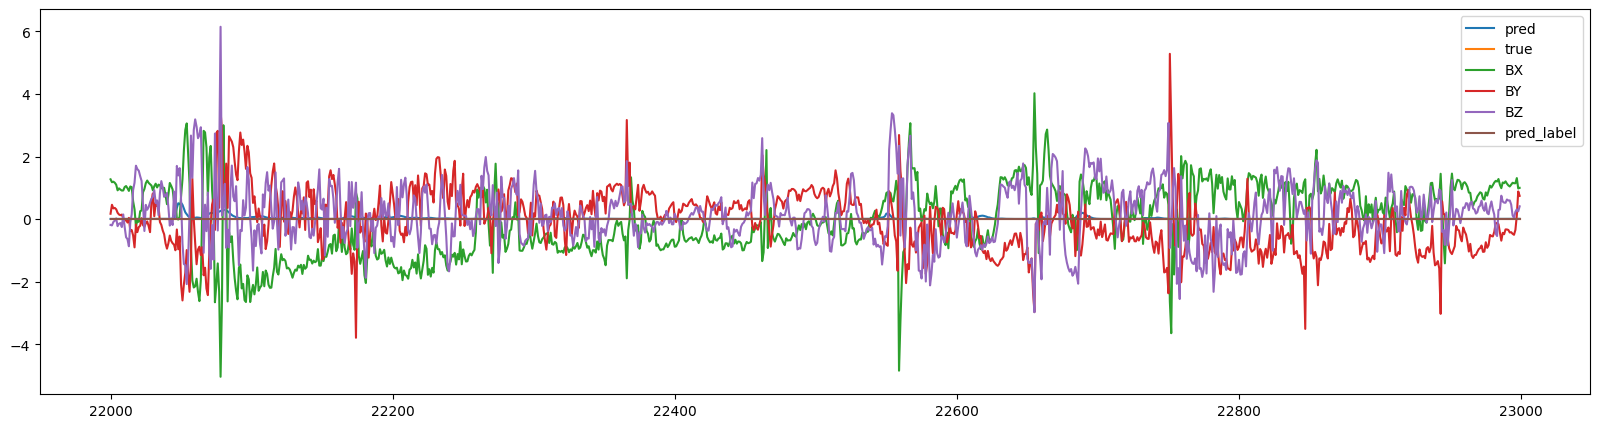

In [ ]:
# Show some CME
mag_names = ['BX', 'BY', 'BZ']
pred_names = ['pred', 'true', 'pred_label']

df_pred_plot = df_pred.copy()
df_pred_plot[pred_names] *= 5
for i in range(0, 40):
    df_pred_plot.iloc[i*1000:(i+1)*1000].plot(figsize=(20, 5))
    plt.show()